## Data Import from Website

The required packages are
- Obspy: for working with earthquake seimsic data
- Basemap or Cartopy: for plotting maps

In [31]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num

from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees

53 Event(s) in Catalog:
2017-11-13T19:31:29.050000Z | +36.630, -121.244 | 4.58 Mw | manual
2016-07-19T21:38:38.910000Z | +36.693, -121.330 | 4.22 Mw | manual
...
2001-07-03T19:02:50.790000Z | +36.695, -121.328 | 4.1 Mw | manual
2001-07-02T17:33:53.680000Z | +36.695, -121.328 | 4.1 Mw | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


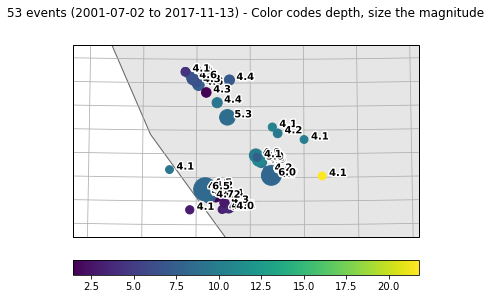

In [32]:
# define station and other parameters
networkName      = "BK"
stationName      = "PKD"
clientName       = "NCEDC"
starttime        = UTCDateTime("2000-01-01")
endtime          = UTCDateTime("2018-04-06")
maxRadius        = 1
minMagnitude     = 4
channelName      = "LHZ"

client = Client(clientName)
inventory = client.get_stations(network=networkName, station=stationName)
station = inventory[0][0]
cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=minMagnitude, latitude=station.latitude, longitude=station.longitude, maxradius=maxRadius)

print(cat)  
cat.plot(projection="local");

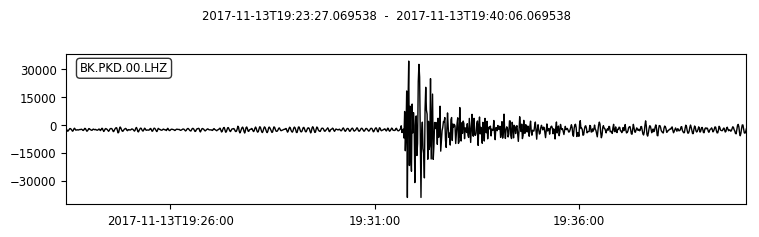

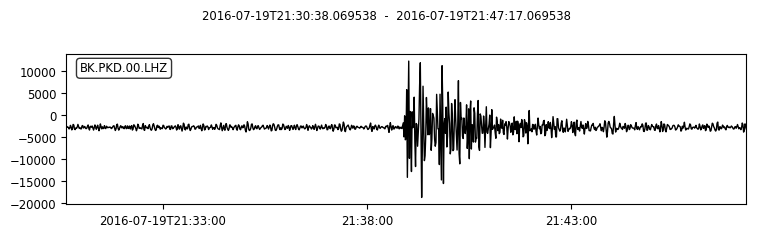

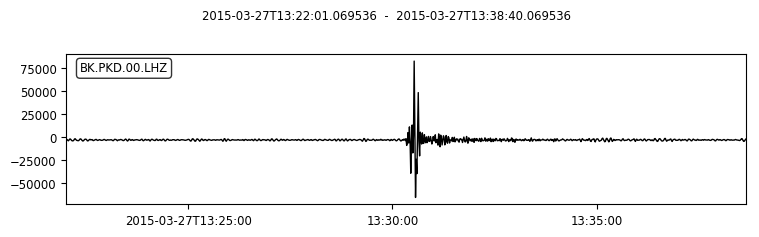

In [33]:
model = TauPyModel(model="iasp91")
nEvents = len(cat)
for i in range(0, 3):
    try:
        event = cat[i]
        origin = event.origins[0]
        distance, _, _ = gps2dist_azimuth(origin.latitude, origin.longitude, station.latitude, station.longitude)
        distance = kilometer2degrees(distance / 1e3)
        arrivals = model.get_travel_times(origin.depth / 1e3, distance)
        #print(arrivals)
        traveltime = arrivals[0].time
        arrival_time = origin.time + traveltime
        st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-500, endtime=arrival_time+500)
        st.plot()
    except:
        pass

### Extracting raw data from previous trace

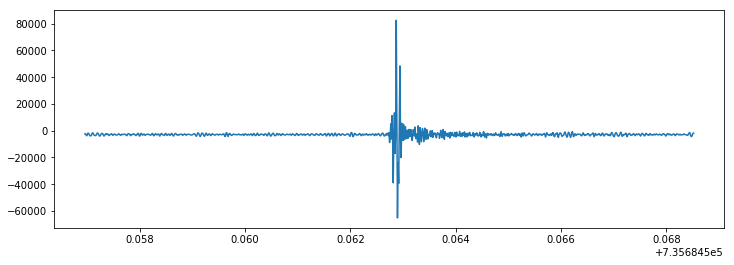

In [34]:
st = st.pop()
x = st.times('matplotlib')
y = st.data
fig = plt.figure(figsize=(12, 4))
plt.plot(x, y, '-')
